# Modeling Traffic Accidents in Copenhagen with a Spatial-Temporal Log Gaussian Cox Process
Within this notebook we implement an Log Gaussian Cox Process (LGCP) over continous space, and discrete (hourly) time. The relevant theory for the notebook is described in detail within sections 4 and 5 of the report.

Imports:

In [126]:
#4.4 material
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal, AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
from pyro.contrib.gp.kernels import RBF, Periodic, Product, RationalQuadratic, Matern32
from pyro.contrib.gp.models import VariationalSparseGP
import pandas as pd
import geopandas as gpd
import torch
import pyro
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

## Data
We begin by importing our dataset. The file we use, df_hourly_full_Q1.csv, includes traffic accident locations and times across Copenhagen during the first quarter of 2023 (sourced from Trafiksstyrelsen), and weather data in Copenhagen during the same period (sourced from Danmarks Meteorologiske Institut). The file is organized through a multi-index which discretizes time by the hour, and space by a 500m by 500m grid. Note that the precise locations (in continuous space) of observed accidents are saved in the columns X and Y, with NaN values for time-space pairs which had no accidents. Within model 4.4, only the data from Trafiksstyrelsen is used. 

In [127]:
df = pd.read_csv('./data/df_hourly_full_Q1.csv', parse_dates=['datetime'])
df.set_index(['datetime', 'cell_id'], inplace=True)
df

acc_precip  mean_temp  \
datetime            cell_id                                            
2023-01-01 00:00:00 (721516.001, 6173966.657)         1.1     282.25   
                    (721516.001, 6174466.657)         1.1     282.25   
                    (721516.001, 6177966.657)         1.1     282.25   
                    (721516.001, 6178466.657)         1.1     282.25   
                    (722016.001, 6173966.657)         1.1     282.25   
...                                                   ...        ...   
2023-03-31 23:00:00 (726016.001, 6175966.657)         0.0     276.15   
                    (726016.001, 6176466.657)         0.0     276.15   
                    (726016.001, 6176966.657)         0.0     276.15   
                    (726016.001, 6177466.657)         0.0     276.15   
                    (726016.001, 6177966.657)         0.0     276.15   

                                               mean_relative_hum  \
datetime            cell_id                                        
2023-01-01 00:00:00 (721516.001, 6173966.657)               99.0   
                    (721516.001, 6174466.657)               99.0   
                    (721516.001, 6177966.657)               99.0   
                    (721516.001, 6178466.657)               99.0   
                    (722016.001, 6173966.657)               99.0   
...                                                          ...   
2023-03-31 23:00:00 (726016.001, 6175966.657)               90.7   
                    (726016.001, 6176466.657)               90.7   
                    (726016.001, 6176966.657)               90.7   
                    (726016.001, 6177466.657)               90.7   
                    (726016.001, 6177966.657)               90.7   

                                               mean_wind_speed  \
datetime            cell_id                                      
2023-01-01 00:00:00 (721516.001, 6173966.657)              1.6   
                    (721516.001, 6174466.657)              1.6   
                    (721516.001, 6177966.657)              1.6   
                    (721516.001, 6178466.657)              1.6   
                    (722016.001, 6173966.657)              1.6   
...                                                        ...   
2023-03-31 23:00:00 (726016.001, 6175966.657)              3.3   
                    (726016.001, 6176466.657)              3.3   
                    (726016.001, 6176966.657)              3.3   
                    (726016.001, 6177466.657)              3.3   
                    (726016.001, 6177966.657)              3.3   

                                               mean_radiation  acc_count   X  \
datetime            cell_id                                                    
2023-01-01 00:00:00 (721516.001, 6173966.657)             0.0          0 NaN   
                    (721516.001, 6174466.657)             0.0          0 NaN   
                    (721516.001, 6177966.657)             0.0          0 NaN   
                    (721516.001, 6178466.657)             0.0          0 NaN   
                    (722016.001, 6173966.657)             0.0          0 NaN   
...                                                       ...        ...  ..   
2023-03-31 23:00:00 (726016.001, 6175966.657)             0.0          0 NaN   
                    (726016.001, 6176466.657)             0.0          0 NaN   
                    (726016.001, 6176966.657)             0.0          0 NaN   
                    (726016.001, 6177466.657)             0.0          0 NaN   
                    (726016.001, 6177966.657)             0.0          0 NaN   

                                                Y  hour  
datetime            cell_id                              
2023-01-01 00:00:00 (721516.001, 6173966.657) NaN     0  
                    (721516.001, 6174466.657) NaN     0  
                    (721516.001, 6177966.657) NaN     0  
                    (721516.001, 61

Here we prepare the input tensors for the LGCP model.

In [128]:
df_day = df.dropna().copy()

# --- First build observation tensors

# spatial accident coordinates (km, already re-centred at SW = 0,0)
xy = df_day[["X","Y"]].values / 1_000.0
xy = xy - xy.min(0, keepdims=True)

# observed hour_of_day in accidents (0 to 23)
h_obs  = df_day["hour"].values.astype(float)

# accident space tensor (N,2)
acc_obs = torch.tensor(xy, dtype=torch.float32)

N, _ = acc_obs.shape

# Now build the quadrature points for the GP
# Define M quadrature points uniformly over the bounding box of coords
M_space = 1200           # number of spatial quadrature points. Higher is more accurate, but slower
M_time  = 24             # one for each hour
M       = M_space * M_time # We have one quadrature point for every spatial quadrature point at every hour of the day

# Compute bounding‐box mins and ranges as tensors
mins_xy   = torch.tensor(xy.min(0))
ranges_xy = torch.tensor(xy.max(0) - xy.min(0))

# sample spatial part
U_xy = (torch.rand(M_space,2) * ranges_xy + mins_xy)  # (M_space,2)

# deterministic hourly grid 0 to 23
U_h  = torch.arange(0,24, dtype=torch.float32).reshape(-1,1) # (24,1)
h_quad = U_h.repeat(M_space,1)  # (M,)

# study-volume = spatial-area [km²] × 24 h
area_space = (ranges_xy[0] * ranges_xy[1])         # km²
volume     = area_space * 24                       # km²·h

# make time‐bins periodic
sin_h_obs   = torch.sin(2*torch.pi*torch.tensor(h_obs))
cos_h_obs   = torch.cos(2*torch.pi*torch.tensor(h_obs))
hours   = torch.arange(M_time, dtype=torch.float32)  # [0, 1, …, 23]
sin_time = torch.sin(2 * torch.pi * hours / M_time)   # (24,)
cos_time = torch.cos(2 * torch.pi * hours / M_time)   # (24,)

# repeat each spatial point for every hour, shape (M_space * M_time, 2)
U_quad = U_xy.repeat_interleave(M_time, dim=0)

# repeat the sin/cos arrays so they line up with U_quad
sin_h_quad = sin_time.repeat(M_space)
cos_h_quad = cos_time.repeat(M_space)

# concatenate obs and quad to make the full sin_h, cos_h
sin_h = torch.cat([sin_h_obs, sin_h_quad], dim=0)
cos_h = torch.cat([cos_h_obs, cos_h_quad], dim=0)


## Model 4.3: Continuous-Spatial Discrete-Temporal Log Gaussian Cox Process
This model incorporates time by using the intensity function:
$$
\log(\lambda(s,t))=f(s)+\beta_0+\beta_r r(s,t) + \gamma_{sin}sin_h(t)+ \gamma_{cos}cos_h(t)
$$

Now we define model 4.4 according to the PGM appearing in figure 6

In [129]:
class SparseLGCP3D(pyro.nn.PyroModule):
    r"""
    Sparse-GP Log-Gaussian Cox Process with
    inputs (x,y), hour_of_day and amount of rain.
    """
    def __init__(self, spatial_kernel_cls, input_dim=2, m_inducing=500):
        super().__init__()
        self.kernel = spatial_kernel_cls(input_dim=input_dim) # (x,y) spatial kernel
        self.m_ind   = m_inducing
        self.vgp     = None

    def _ensure_vgp(self, X_all):
        if self.vgp is not None:
            return
        m = min(self.m_ind, X_all.size(0))
        Xu = X_all[torch.randperm(X_all.size(0))[:m]].contiguous()
        self.vgp = VariationalSparseGP(
            X_all, y=None, kernel=self.kernel, Xu=Xu, likelihood=None,
            jitter=1e-4, whiten=True
        )

    # -------------------------------------------------------------
    def model(self, acc_obs, U, V, sin_h, cos_h):
        """
        acc_obs     : (N,2)  spatial km (x,y)
        U           : (M,2)  quadrature spatial km
        V           : scalar area_km² * 24  (same volume used in likelihood)
        sin_h,cos_h : (N,)   sin,cos of hour/24π for obs
        """
        N = acc_obs.shape[0] #the number of observed accidents
        M = U.shape[0]       #the number of quadrature points (number of space quadrature points multiplied by 24 hours)

        # kernel hyper-priors
        ls  = pyro.sample("ls",  dist.LogNormal(np.log(5.), 0.5))        #referred to as l in the report
        var = pyro.sample("var", dist.LogNormal(np.log(1.), 1.0))        #referred to as sigma^2 in the report
        noise  = pyro.sample("noise", dist.LogNormal(np.log(1e-3), 0.5)) #referred to as epsilon in the report

        # Prior on the latent regional factors hyper‐parameters. 
        mu_r    = pyro.sample("mu_r",    dist.Normal(np.log(1.7), 0.5)) 
        sigma_r = pyro.sample("sigma_r", dist.HalfNormal(0.5))          

        # Latent regional factors variable generated to match with observed accidents
        region_gen  = pyro.sample(
            "region_gen",
            dist.LogNormal(mu_r, sigma_r)
                .expand([N])
                .to_event(1)
        )   # shape (N,)

        #generate regional factors based on different quadrature points (locations and times)
        region_quad = pyro.sample(
            "region_quad",
            dist.LogNormal(mu_r, sigma_r)
                .expand([M])
                .to_event(1)
        )   # shape (M,)

        # build design matrix
        sin_h_obs  = sin_h[:N]               # (N,)
        cos_h_obs  = cos_h[:N]               # (N,)
        sin_h_quad = sin_h[N:N+M]            # (M,)
        cos_h_quad = cos_h[N:N+M]            # (M,)

        Z_obs  = torch.cat([acc_obs, sin_h_obs[:, None], cos_h_obs[:, None]], dim=1)   # (N,4)
        Z_quad = torch.cat([U, sin_h_quad[:, None], cos_h_quad[:, None]], dim=1)       # (M,4)
        X_all  = torch.cat([Z_obs[:, :3], Z_quad[:, :3]], dim=0)        # (N+M,3)

        # priors for linear component 
        beta_0  = pyro.sample("beta_0", dist.Normal(-3., 1))
        beta_r  = pyro.sample("beta_r", dist.LogNormal(0., 0.3))
        gamma_sin  = pyro.sample("gamma_sin", dist.Normal(0., 1.))  # sin coeff
        gamma_cos  = pyro.sample("gamma_cos", dist.Normal(0., 1.))  # cos coeff

        # inject GP hypers
        self.kernel.lengthscale = ls
        self.kernel.variance = var
        # build sparse GP prior
        self._ensure_vgp(X_all)
        self.vgp.noise = noise

        f_all = self.vgp.model()[0] # (N+M,)
        f_obs, f_quad = f_all[:N], f_all[N:]

        pyro.deterministic("f", f_all)

        # linear component
        m_obs  = beta_0 + beta_r*region_gen + gamma_sin*sin_h_obs + gamma_sin*cos_h_obs
        m_quad = beta_0 + beta_r*region_quad + gamma_cos*sin_h_quad[:M] + gamma_cos*cos_h_quad[:M]

        # log likelihood
        pyro.factor("obs_ll",  (m_obs  + f_obs ).sum())
        pyro.factor("quad_ll", - (V/M) * torch.exp(m_quad + f_quad).sum())

        pyro.deterministic("log_lambda_quad", m_quad + f_quad)


## Inference
We next run SVI inference as described in section 5.5

In [130]:
kernel_constructors = {
    #"RBF": RBF,
    "Matern 3/2": Matern32,
    #"RationalQuadratic": RationalQuadratic,
}

results = []
for name, Kcls in kernel_constructors.items():
    print(f"\n=== Sparse kernel: {name} ===")
    module = SparseLGCP3D(Kcls)
    model  = module.model
    guide  = AutoDiagonalNormal(model, init_loc_fn=pyro.infer.autoguide.init_to_median)

    pyro.clear_param_store()
    svi = SVI(model, guide, ClippedAdam({"lr":1e-2}), Trace_ELBO())
    for step in range(500):
        loss = svi.step(acc_obs, U_quad, volume, sin_h, cos_h)
        if step % 50 == 0:
            print(f"step {step:3d}  ELBO = {-loss:.1f}") # ELBO = –loss

    final_elbo = -loss
    results.append({"kernel": name,
                    "ELBO": final_elbo,
                    "model": model,
                    "guide": guide})

df_result = pd.DataFrame(results).set_index("kernel")
print(df_result)



=== Sparse kernel: Matern 3/2 ===
step   0  ELBO = -16285.7
step  50  ELBO = -3900.6
step 100  ELBO = -2727.4
step 150  ELBO = -3290.7
step 200  ELBO = -848.1
step 250  ELBO = -589.6
step 300  ELBO = -340.5
step 350  ELBO = -153.0
step 400  ELBO = -26.4
step 450  ELBO = -135.2
                  ELBO                                              model  \
kernel                                                                      
Matern 3/2  154.774008  <bound method SparseLGCP3D.model of SparseLGCP...   

                           guide  
kernel                            
Matern 3/2  AutoDiagonalNormal()  


Obtain posterior samples and plot intensities

/var/folders/h6/d2ttd9q92dqcvwk3_r7sjb180000gn/T/ipykernel_63465/1048095166.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km   = U_xy + offset_km          # (M,2)


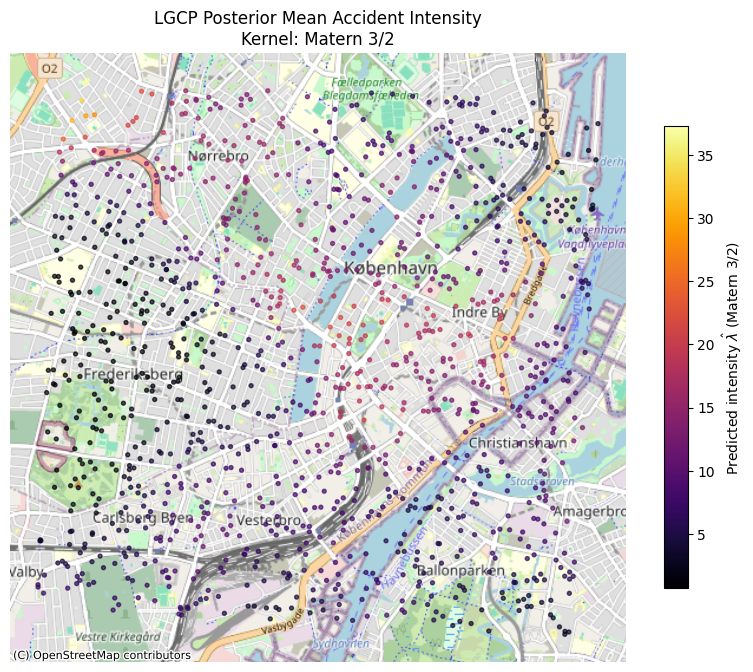

In [131]:
for name, row in df_result.iterrows():
    model = row['model']
    guide = row['guide']

    # Draw samples from the variational posterior
    predictive = Predictive(model, guide=guide, num_samples=400)
    samples    = predictive(acc_obs, U_quad, volume, sin_h, cos_h)
    
    lambda_quad_samples = torch.exp(samples["log_lambda_quad"])        # (S, M)
    lambda_quad_mean    = lambda_quad_samples.mean(0)
    
    # calculate the absolute coordinates in metres
    coords_orig = df_day[["X","Y"]].dropna().values / 1000.0  # km
    offset_km  = coords_orig.min(axis=0) # still (2,)

    # add the offset in km, then convert to metres
    abs_U_km   = U_xy + offset_km          # (M,2)
    abs_U_m    = abs_U_km * 1000.0       # (M,2)

    # Build GeoDataFrame — geometry only uses x,y
    T = 24
    S = M // T    # number of spatial locations

    # reshape into (spatial, time)
    intensity_matrix = lambda_quad_mean.reshape(S, T)        # shape (S, 24)

    # per day at location i is simply the sum over t
    daily_intensity = intensity_matrix.sum(axis=1)           # shape (S,)

    # now build your GeoDataFrame with daily_rate instead of λ_quad_mean:
    gdf = gpd.GeoDataFrame(
        {"daily_intensity": daily_intensity},
        geometry=gpd.points_from_xy(
            abs_U_km[:, 0].numpy() * 1000,
            abs_U_km[:, 1].numpy() * 1000
            ),
        crs="EPSG:25832"
    ).to_crs(epsg=3857)

    gdf_web = gdf.to_crs(epsg=3857)

    # Plot on map
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_web.plot(
        column="daily_intensity",
        ax=ax,
        markersize=8,
        alpha=0.7,
        cmap="inferno",
        legend=True,
        legend_kwds={"label": f'Predicted intensity $\\hat\\lambda$ ({name})', "shrink":0.6}
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.set_title(f"LGCP Posterior Mean Accident Intensity\nKernel: {name}")
    plt.tight_layout()
    plt.show()

Plot the parameter distributions

ls        mean=5.673   sd=3.310
var       mean=1.369   sd=1.475
noise     mean=0.001   sd=0.001
beta_0    mean=-3.185   sd=0.083
gamma_sin  mean=4.993   sd=0.121
gamma_cos  mean=0.013   sd=0.062
mu_r      mean=0.424   sd=0.004
sigma_r   mean=0.160   sd=0.001
beta_r    mean=1.220   sd=0.049


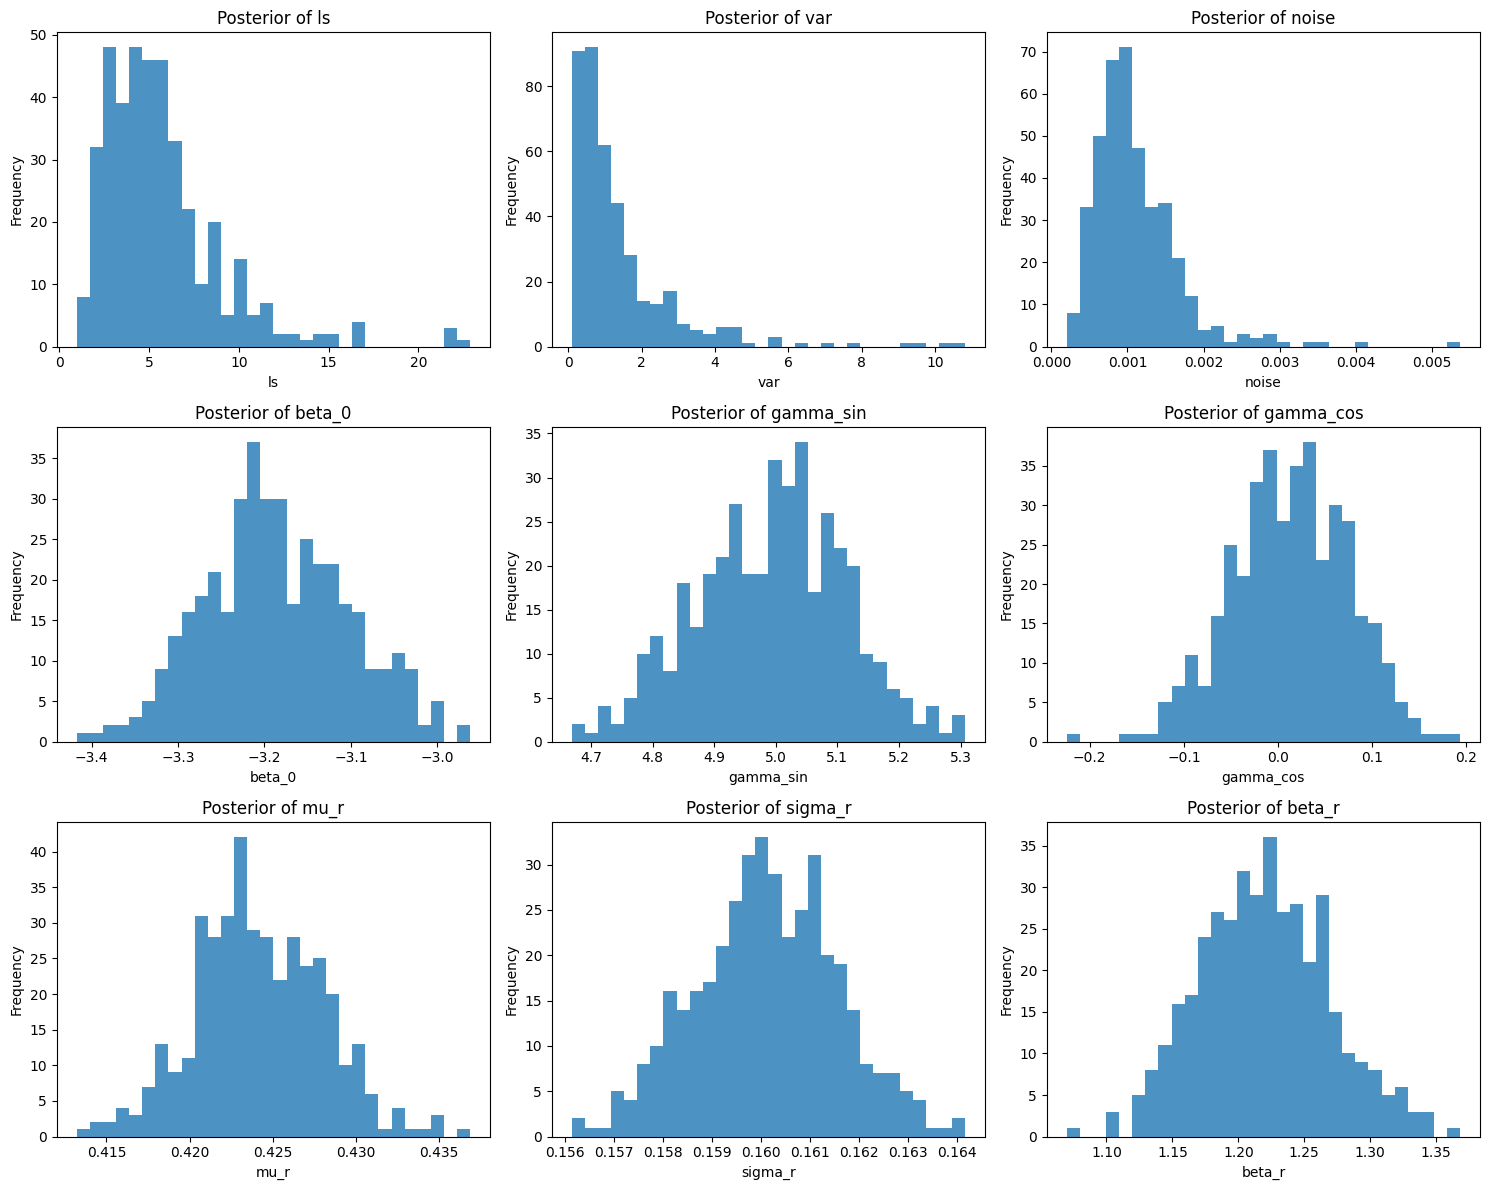

In [132]:
hyperparams = [
    "ls", "var", "noise",
    "beta_0", "gamma_sin", "gamma_cos",
    "mu_r", "sigma_r", "beta_r"

]
hp_values = {
    hp: samples[hp].detach().cpu().numpy().ravel()
    for hp in hyperparams
}

# print summary statistics
for hp, vals in hp_values.items():
    mean = np.mean(vals)
    sd   = np.std(vals)
    print(f"{hp:8s}  mean={mean:.3f}   sd={sd:.3f}")

# plot histograms in a grid
n_cols = 3
n_rows = int(np.ceil(len(hyperparams) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, hp in zip(axes, hyperparams):
    ax.hist(hp_values[hp], bins=30, alpha=0.8)
    ax.set_title(f"Posterior of {hp}")
    ax.set_xlabel(hp)
    ax.set_ylabel("Frequency")

# hide any unused subplots
for ax in axes[len(hyperparams):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Analytics
This section corresponds to section 6 in the report



We can use the model to answer questions such as
1. How many accidents in a given day?
2. What is the probability of zero accidents in a day?
3. What is the probability of an accident in a given location over $t$ time?

Future questions:
4. Where is the 90 % credible hotspot? Eg. the smallest region that contains 90\% of the total predicted intensity

In [133]:
n_days = 31+28+31  # days in Jan, Feb, Mar

# compute Lambda for each posterior draw
lambda_q = torch.exp(samples["log_lambda_quad"])    # (S, M)
Lambda = (volume / M) * lambda_q.sum(dim=1)              # (S,)

# posterior expected accidents
expected_accidents = Lambda.mean().item() / n_days  # average per day
print("E[number of accidents/day] = ", expected_accidents)
print("Std[number of accidents/day] = ", Lambda.std().item() / n_days)

E[number of accidents/day] =  2.2123545224649424
Std[number of accidents/day] =  0.6872840522651275


In [134]:
Lambda_day = Lambda / n_days   # (S,)  per-day rate

p_zero_each = torch.exp(-Lambda_day)   # (S,)
p_zero = p_zero_each.mean().item()
print("P(no accidents in a day) ≈", p_zero)


P(no accidents in a day) ≈ 0.13139551305523636


## Legacy Model 4.3: Spatially-Continuous Log Gaussian Cox Process with Weather
This section outlines the code for our LGCP model from 4.3 which incorperates weather by using the intensity function:
$$
\log(\lambda(s))=f(s)+\beta^T w(s)
$$
Where $w(s)$ is the weather at a particular point in space, and $f(s)$ is drawn from a Guassian Process over the continous space as done in 4.2 and 4.4.

Imports

In [135]:
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from torch.linalg import cholesky
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.contrib.gp.kernels import RBF, Matern32, RationalQuadratic
import pandas as pd
import geopandas as gpd
import torch
import pyro
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

## Data
For model 4.3, we use two files:  df_hourly_janaury.csv, which contains data on traffic accidents within Copenhagen during January 2023. And 2023_Weather.csv, which contains hourly weather data for Copenhagen in 2023. As with 4.4, these data are sourced from Trafiksstyrelsen and DMI. Note that the temperature data is in Celsius, but we convert it to Kelvin (as described in 3.2).

In [136]:

#accident dataframe
df = pd.read_csv('./data/df_hourly_january.csv', parse_dates=['datetime'])
df["datetime"] =  pd.to_datetime(df['datetime'])
df.set_index(['datetime', 'cell_id'], inplace=True)
#weather dataframe for all of 2023. Since there is only accident data for january, the extra time is filtered out later
weather23 = pd.read_csv("./data/2023_Weather.csv")
weather23.rename(columns={"Time":"datetime"},inplace=True)
weather23["datetime"] =  pd.to_datetime(weather23['datetime'])
weather23.drop(columns="Unnamed: 0",inplace=True)
weather23


#Here we combine the datasets into one
df_reset = df.reset_index()
merged1 = pd.merge(weather23, df_reset, on='datetime')
# Set back the original multiindex
merged1["mean_temp"] = merged1["mean_temp"]+273.15
merged1 = merged1.set_index(['cell_id', 'datetime'])
merged1


#drop all rows with no X and Y data (IE, rows without accidents.)
#since we only use accident data for january, this also drops all months BESIDES for january
merged2 = merged1[merged1['X'].notna()].reset_index(drop=True)
if merged2["Y"].isna().any():
    print("Warning: NaNs found in Y column.")
    raise ValueError("Each observed accident must have coordinates. An accident was found with no Y coordinate.")
merged2

,acc_precip,mean_temp,mean_relative_hum,mean_wind_speed,mean_radiation,acc_count,X,Y
0,3.5,282.15,99.3,1.7,0.0,1,722486.694,6174248.234
1,0.6,280.45,99.2,2.0,0.0,1,725696.001,6172194.001
2,0.6,280.45,99.2,2.0,0.0,1,725480.428,6175703.304
3,0.3,282.95,99.0,3.8,12.0,1,723337.001,6178326.001
4,0.1,282.45,96.2,5.1,9.0,1,725598.232,6177460.554
...,...,...,...,...,...,...,...,...
104,0.0,276.55,68.3,6.8,0.0,1,721998.280,6178558.317
105,0.0,274.95,85.0,3.7,0.0,1,726466.742,6174562.202
106,0.8,277.35,98.0,3.7,46.0,1,724296.440,6176788.883
107,0.1,278.55,96.7,5.6,66.0,1,723749.973,6174143.985


Preparing the input tensors.

In [137]:
df_day = merged2.copy()

# Convert UTM (metres) to kilometres for nicer kernel length‑scale priors
# coords: accident locations in km after centering, shape (N,2)
coords = df_day[["X", "Y"]].values / 1_000.0  # shape (n_points, 2)

# Re‑centre so the south‑west corner is (0,0) and make it a tensor
coords = coords - coords.min(0, keepdims=True)
coords = torch.Tensor(coords).detach().clone()

# Define M quadrature points uniformly over the bounding box of coords
N, _ = coords.shape
M = 1000  # Numper of samples 

# Compute bounding‐box mins and ranges as tensors
x_min, y_min = coords.min(0).values          # both floats
x_max, y_max = coords.max(0).values          # both floats
mins   = torch.tensor([x_min, y_min])        # shape (2,)
ranges = torch.tensor([x_max - x_min,
                       y_max - y_min])      # shape (2,)

# Draw M uniform points in [0,1]^2, then scale & shift
U = torch.rand(M, 2) * ranges[None, :] + mins[None, :]  # shape (M,2)

# Compute domain area in km² for the bounding box
area = (x_max - x_min) * (y_max - y_min)

# Pre-stack all locations for the GP: first the observed points, then quadrature
X_all = torch.cat([coords, U], dim=0)  # shape (N+M, 2)


## Model 4.3 Code
One of the characteristic features of model 4.3 is the ability to add a weather query: I.E., you can specify weather conditions in Copenhagen as an observed variable input, which the model will use when calculated the posterior distribution. The aim here is to be able to answer questions like:
* Given the weather outside now, what is the distribution of traffic accident risk across Copenhagen?
* What about with hypothetical weather conditions?


This form of model could therefore be useful to authories aiming to assess dangers in traffic as a function of weather.


The query:

In [138]:
#here you can put the specific weather you want to test. Chack 3.2 for additional information.
precip = 0      #0+
temp = 0        #0+ (note: Kelvin)
hum = 0         #0-100
wind = 0        #0+
radiation = 0   #0+

weather_obs = torch.tensor(
    merged2[["acc_precip", "mean_temp", "mean_relative_hum", "mean_wind_speed", "mean_radiation"]].values,
    dtype=torch.float
)

weather_query = torch.tensor([precip, temp, hum, wind, radiation])
weather_quad = weather_query.expand(M, 5)
#note that we use the same weather across all quadrature points. This represents consistent weather across all of Copenhagen
#These inputs could be modified to have different weather occurring at different portions of the city.


The model:

In [139]:


class LogGaussianCoxProcess():
    def __init__(self, kernel_cls, input_dim=2):
        self.kernel = kernel_cls(input_dim=input_dim)

    def model(self, coords, U, area, weather_obs,weather_quad):
        """
        coords:   (N,2) tensor of observed accident locations
        U:        (M,2) tensor of quadrature locations (inside study area)
        area:     float, total area of study region
        """
        weather_obs = weather_obs.to(dtype=torch.float)
        weather_quad = weather_quad.to(dtype=torch.float)
        N = coords.shape[0]
        M = U.shape[0]
        D = weather_obs.shape[1]
        #expand in pyro?
        beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))  # shape (D,) IE, 5 since we have 5 types of weather data
        
        # Sample kernel hyper‐parameters (priors), and set them in the kernel
        ls    = pyro.sample("ls", dist.LogNormal(0., 0.5))
        var   = pyro.sample("var",    dist.LogNormal(0., 1.0))
        noise = pyro.sample("noise",       dist.LogNormal(-3., 0.3))
        self.kernel.lengthscale = ls
        self.kernel.variance    = var

        # Build full covariance over all points
        X_all = torch.cat([coords, U], dim=0)       # shape (N+M, 2)
        K = self.kernel(X_all)        
        K = 0.5*(K + K.T)                            # enforce symmetry
        K = K + (noise + 1e-4) * torch.eye(N+M)     # jitter + noise
        L = cholesky(K)                             # lower‐Cholesky

        # Sample the latent GP at all points
        f_all = pyro.sample(
            "f_all",
            dist.MultivariateNormal(
                loc=torch.zeros(N+M),
                scale_tril=L
            )
        )

        # Split into observed vs quadrature
        f_obs  = f_all[:N]      # latent at each accident
        f_quad = f_all[N:]      # latent at each quadrature site
        f_obs = f_obs + (weather_obs @ beta)      # shape (N,)
        f_quad = f_quad + (weather_quad @ beta)   # shape (M,)

        # Log‐likelihood via Monte‐Carlo quadrature, 
        with pyro.plate("obs", N):
            # each observed point contributes +f(x_i) to the log‐likelihood
            pyro.factor("obs_ll", f_obs)

        with pyro.plate("quad", M):
            # each quadrature point contributes −(area/M) * exp(f(u_j))
            pyro.factor("quad_ll", - (area / M) * torch.exp(f_quad))

## Inference
Run inference with SVI/MCMC

In [140]:
# List of kernels to compare
kernel_constructors = {
    "RBF": RBF,
    "RationalQuadratic": RationalQuadratic,
}

results = []

for name, Kclass in kernel_constructors.items():
    print(f"\n=== Kernel: {name} ===")
    model = LogGaussianCoxProcess(Kclass).model
    guide = AutoDiagonalNormal(model)
    

    pyro.clear_param_store()
    #specifics of SVI function?
    svi = SVI(model, guide, ClippedAdam({"lr":1e-2}), Trace_ELBO())
    # run SVI
    for step in range(1000):
        """if step % 100 == 0:
            print(f"[step {step:4d}]  ELBO = {-svi.step(coords, U, area,weather_obs,weather_quad):.2f}")
        svi.step(coords, U, area, weather_obs,weather_quad)"""
        loss = svi.step(coords, U, area, weather_obs, weather_quad)
        if step % 100 == 0:
            print(f"[step {step:4d}]  ELBO = {-loss:.2f}")
    elbo = -loss  # final ELBO estimate

    results.append({"kernel": name, "ELBO": elbo, "model": model, "guide": guide})

df_result = pd.DataFrame(results).set_index("kernel")





=== Kernel: RBF ===
[step    0]  ELBO = -14096.52
[step  100]  ELBO = 25230.07
[step  200]  ELBO = 69626.12
[step  300]  ELBO = 111067.59
[step  400]  ELBO = 151368.81
[step  500]  ELBO = 196768.70
[step  600]  ELBO = 236690.67
[step  700]  ELBO = 285578.21
[step  800]  ELBO = 323163.19
[step  900]  ELBO = 370041.37

=== Kernel: RationalQuadratic ===
[step    0]  ELBO = 25830.45
[step  100]  ELBO = 69639.94
[step  200]  ELBO = 107317.34
[step  300]  ELBO = 157472.66
[step  400]  ELBO = 199233.01
[step  500]  ELBO = 235682.58
[step  600]  ELBO = 288014.58
[step  700]  ELBO = 315904.29
[step  800]  ELBO = 371285.05
[step  900]  ELBO = 408403.20


Plotting

/var/folders/h6/d2ttd9q92dqcvwk3_r7sjb180000gn/T/ipykernel_63465/2132304428.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km    = U + offset_km                            # (M,2) in km


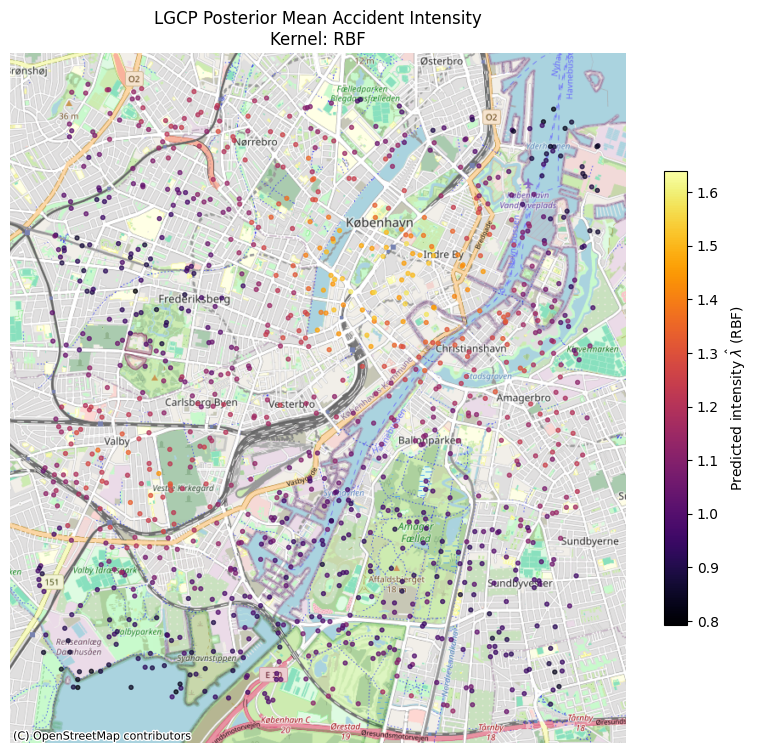

ls: mean=1.140, sd=0.533
var: mean=1.498, sd=1.644
noise: mean=0.087, sd=0.004


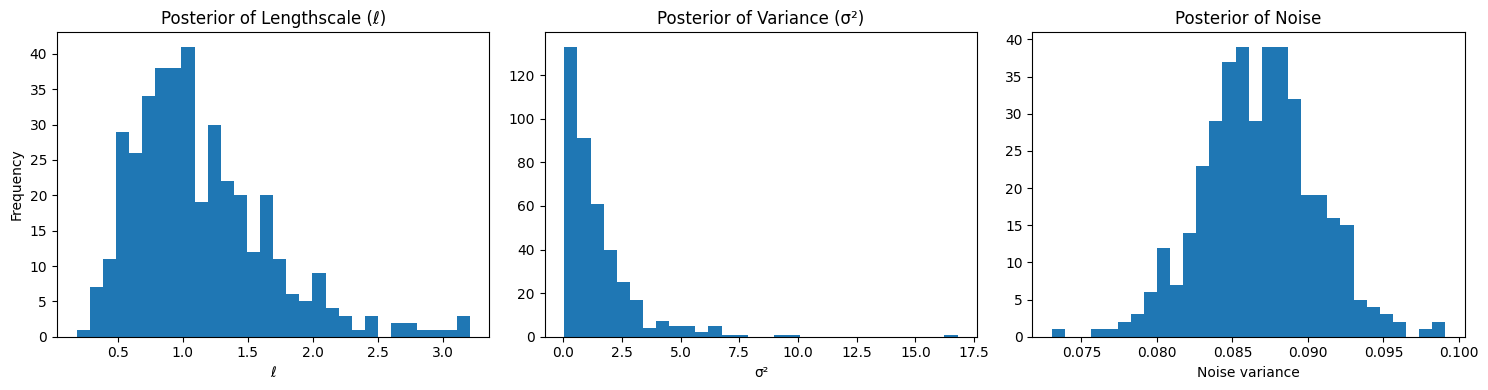

beta mean: [10.071673  9.475414  9.657393 10.010828 10.226446]
beta std: [0.7078307  0.12865967 0.09636658 0.12346343 0.10930289]
β[0] = 10.072 ± 0.708
β[1] = 9.475 ± 0.129
β[2] = 9.657 ± 0.096
β[3] = 10.011 ± 0.123
β[4] = 10.226 ± 0.109


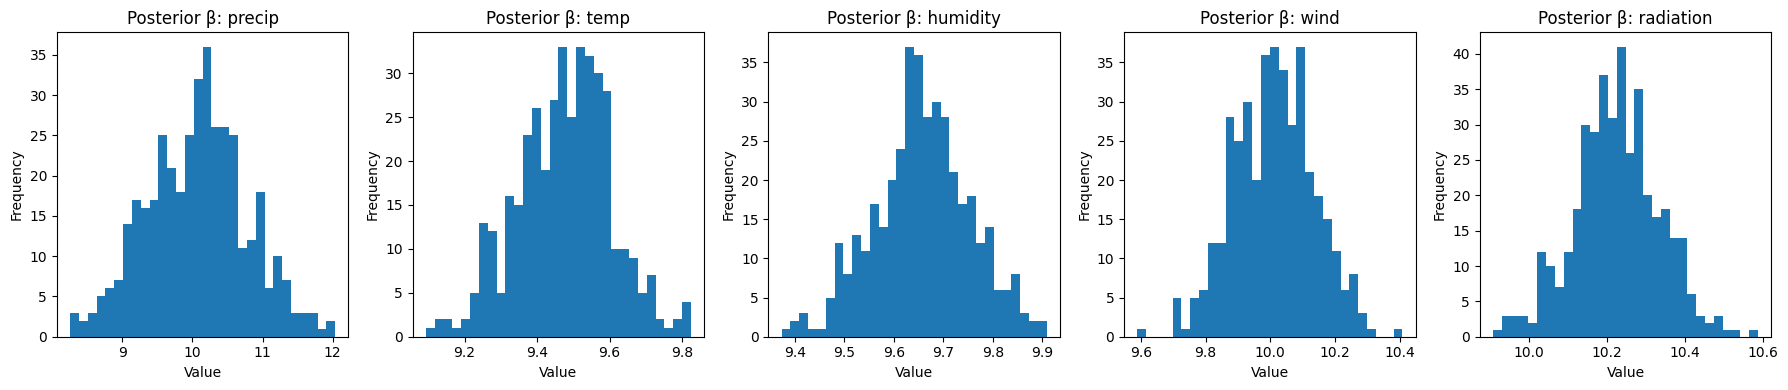

/var/folders/h6/d2ttd9q92dqcvwk3_r7sjb180000gn/T/ipykernel_63465/2132304428.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km    = U + offset_km                            # (M,2) in km


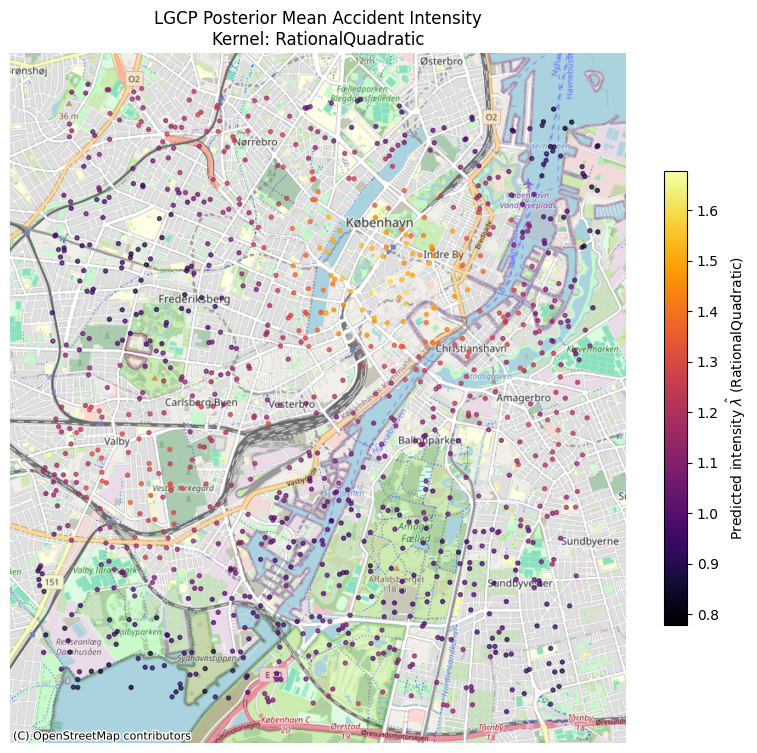

ls: mean=1.190, sd=0.582
var: mean=1.554, sd=1.793
noise: mean=0.090, sd=0.004


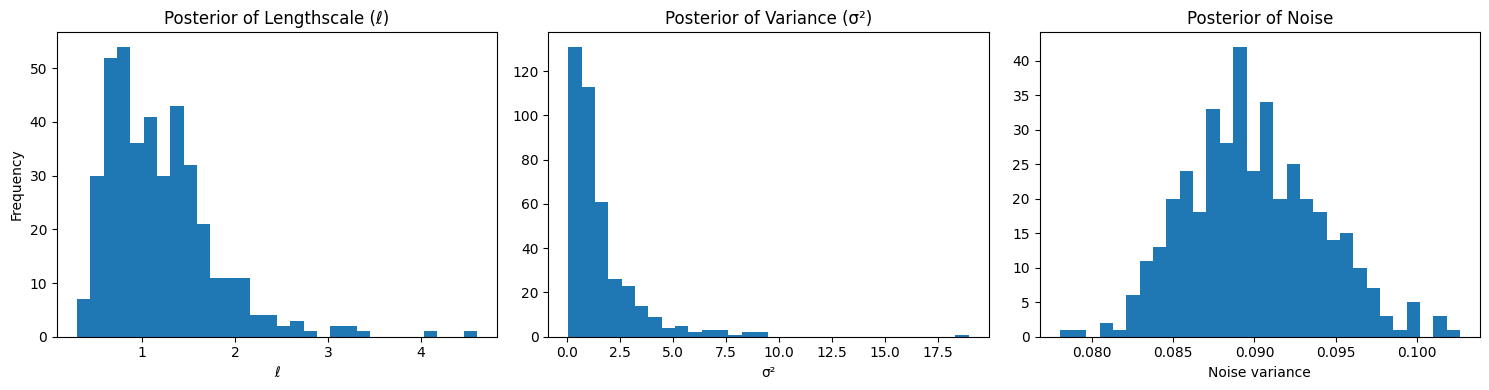

beta mean: [10.216403 10.770855 10.094362 10.425006 10.166895]
beta std: [0.68928355 0.12733524 0.0984352  0.12534976 0.11042254]
β[0] = 10.216 ± 0.689
β[1] = 10.771 ± 0.127
β[2] = 10.094 ± 0.098
β[3] = 10.425 ± 0.125
β[4] = 10.167 ± 0.110


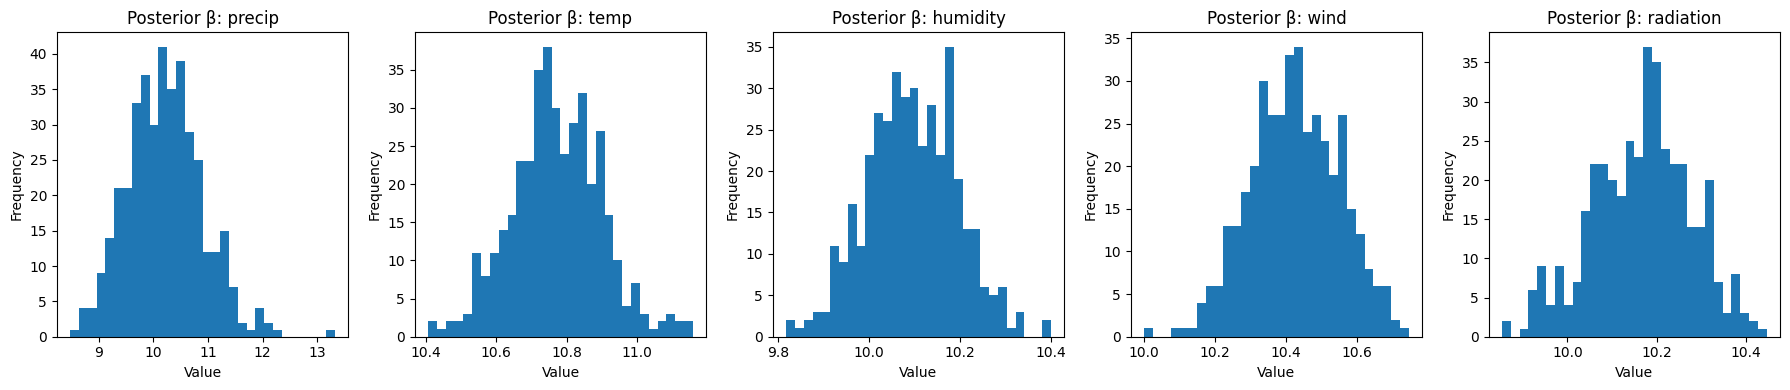

In [141]:
for name, row in df_result.iterrows():
    model = row['model']
    guide = row['guide']

    # Draw samples from the variational posterior
    predictive = Predictive(model, guide=guide, num_samples=400)
    samples    = predictive(coords, U, area,weather_obs,weather_quad)
    
    # Monte Carlo posterior mean of f_all
    f_all_post = samples["f_all"].mean(0).squeeze()   # shape (N+M,)
    
    # Slice into obs vs quad
    N = coords.size(0)
    f_quad_mean = f_all_post[N:] # shape (M,)
    
    # Compute intensities at quadrature points
    lambda_quad = torch.exp(f_quad_mean)    # shape (M,)
    
    # Compute original UTM shift
    coords_orig = df_day[["X","Y"]].dropna().values / 1000.0  # km
    offset_km   = coords_orig.min(axis=0)                  # (x_min, y_min) in km
    abs_U_km    = U + offset_km                            # (M,2) in km
    abs_U_m     = abs_U_km * 1000.0                        # (M,2) in metres

    # Build GeoDataFrame
    df_plot = gpd.GeoDataFrame(
        {"intensity": lambda_quad.numpy()},
        geometry=[Point(x, y) for x, y in abs_U_m.numpy()],
        crs="EPSG:25832"
    )
    gdf_web = df_plot.to_crs(epsg=3857)

    # Plot on map
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_web.plot(
        column="intensity",
        ax=ax,
        markersize=8,
        alpha=0.7,
        cmap="inferno",
        legend=True,
        legend_kwds={"label": f'Predicted intensity $\\hat\\lambda$ ({name})', "shrink":0.6}
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.set_title(f"LGCP Posterior Mean Accident Intensity\nKernel: {name}")
    plt.tight_layout()
    plt.show()

    # Summary hyperparameters
    for name in ["ls","var","noise"]:
        vals = samples[name]
        print(f"{name}: mean={vals.mean():.3f}, sd={vals.std():.3f}")

    # Plot hyperparameter posteriors
    ls_samples = samples["ls"].detach().cpu().numpy()
    var_samples = samples["var"].detach().cpu().numpy()
    noise_samples = samples["noise"].detach().cpu().numpy()

    # Plot histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].hist(ls_samples, bins=30)
    axes[0].set_title("Posterior of Lengthscale (ℓ)")
    axes[0].set_xlabel("ℓ")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(var_samples, bins=30)
    axes[1].set_title("Posterior of Variance (σ²)")
    axes[1].set_xlabel("σ²")

    axes[2].hist(noise_samples, bins=30)
    axes[2].set_title("Posterior of Noise")
    axes[2].set_xlabel("Noise variance")

    plt.tight_layout()
    plt.show()

    beta_samples = samples["beta"].detach().cpu().numpy()

    mean_beta = beta_samples.mean(axis=0).flatten()
    std_beta = beta_samples.std(axis=0).flatten()
    print("beta mean:",mean_beta)
    print("beta std:", std_beta)

    for i, (mean, std) in enumerate(zip(mean_beta, std_beta)):
        print(f"β[{i}] = {mean.item():.3f} ± {std.item():.3f}")

    #print("beta samples shape:", beta_samples.shape)
    beta_samples = beta_samples.squeeze(1)  # shape becomes (400, 5)
    #print("beta samples shape:", beta_samples.shape)

    fig, ax = plt.subplots(1, beta_samples.shape[1], figsize=(18, 4))
    weather_names = ["precip", "temp", "humidity", "wind", "radiation"]

    for i in range(beta_samples.shape[1]):
        ax[i].hist(beta_samples[:, i], bins=30)
        ax[i].set_title(f"Posterior β: {weather_names[i]}")
        ax[i].set_xlabel("Value")
        ax[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()
